## **Proactive Fraud Detection in Financial Transactions: A CRISP-DM Approach**

## Business Understanding

Fraudulent transactions in financial systems cause significant monetary losses and can damage customer trust. This project aims to build a machine learning model to proactively detect fraudulent transactions using the dataset provided by the financial company.

**Objectives:**
1. Detect potential fraudulent transactions accurately.
2. Identify the key factors that indicate fraudulent behavior.
3. Recommend preventive measures for reducing fraud risk.

**Key Questions:**
1. What patterns differentiate fraudulent from legitimate transactions?
2. How can the data be prepared to avoid overfitting on non-fraud cases?
3. Which factors most strongly predict fraudulent activity?


## Data Understanding
The dataset contains financial transaction records including both legitimate and fraudulent transactions.  
Our goal is to understand the data, check for missing values, and identify potential leakage columns that could unrealistically improve model performance.



In [27]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("Fraud.csv")  
print("Columns in dataset:\n", df.columns.tolist(), "\n")


Columns in dataset:
 ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'] 



In [ ]:
fraud_cols = [c for c in df.columns if 'fraud' in c.lower()]
flag_cols  = [c for c in df.columns if 'flag' in c.lower()]

print("Columns containing 'fraud':", fraud_cols)
print("Columns containing 'flag':", flag_cols)

preferred_targets = [c for c in fraud_cols if c.lower() in ('isfraud','is_fraud','fraud')]
if preferred_targets:
    target_col = preferred_targets[0]
elif fraud_cols:
    target_col = fraud_cols[0]
else:
    raise KeyError("No fraud-like column found. Please check df.columns.")

print("Using target column:", target_col)

# Leakage columns.
leakage_cols = flag_cols.copy()

Columns containing 'fraud': ['isFraud', 'isFlaggedFraud']
Columns containing 'flag': ['isFlaggedFraud']
Using target column: isFraud


In [ ]:
# Pick target column
preferred_targets = [c for c in fraud_cols if c.lower() in ('isfraud','is_fraud','fraud')]
if preferred_targets:
    target_col = preferred_targets[0]
elif fraud_cols:
    target_col = fraud_cols[0]
else:
    raise KeyError("No fraud-like column found. Please check df.columns.")

print("Using target column:", target_col)

# Drop rows with missing target
df = df.dropna(subset=[target_col])

# Leakage columns
leakage_cols = flag_cols.copy()


Using target column: isFraud


## Correlation Analysis
Understanding relationships between numerical features.


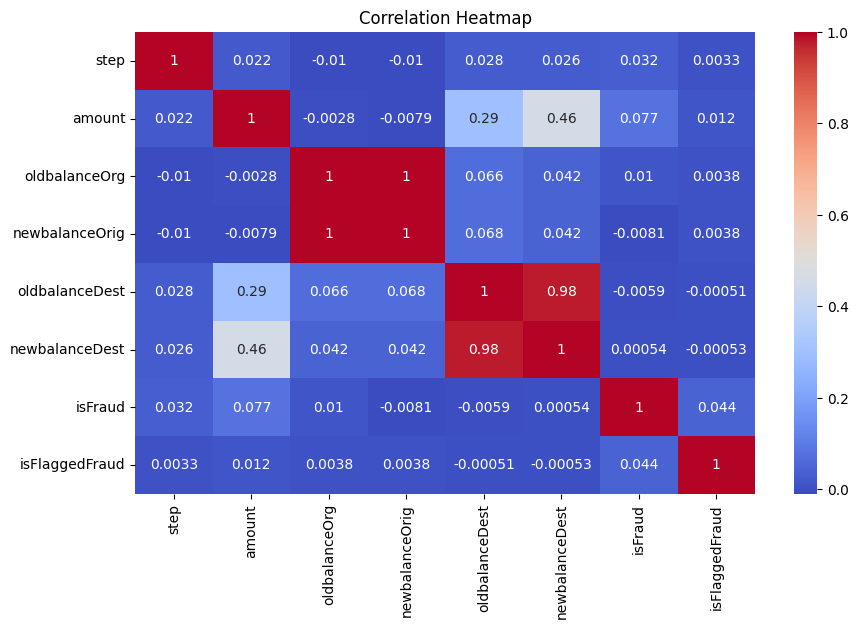

In [28]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Data Preparation
We remove missing values in the target, drop leakage columns, split the data into training and testing sets,
scale numeric features, and address class imbalance with SMOTE.


In [ ]:
X = df.drop(columns=leakage_cols + [target_col], errors='ignore')
y = df[target_col]

print("\nDropped leakage columns:", leakage_cols)
print("Final feature columns count:", X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



Dropped leakage columns: ['isFlaggedFraud']
Final feature columns count: 9


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled  = scaler.transform(X_test[num_cols])

In [24]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

## Modeling
We use a **RandomForestClassifier** with class weighting to handle imbalance.  
This model is chosen for its robustness to multicollinearity, outliers, and its ability to output feature importance.


In [ ]:
model = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1
)
model.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred = model.predict(X_test_scaled)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))



Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     84566
         1.0       0.14      0.44      0.21        43

    accuracy                           1.00     84609
   macro avg       0.57      0.72      0.60     84609
weighted avg       1.00      1.00      1.00     84609

Confusion Matrix:
 [[84445   121]
 [   24    19]]
ROC AUC Score: 0.9693177586901986


## Evaluation
We assess model performance using classification metrics and visualize the ROC curve to measure discrimination ability.


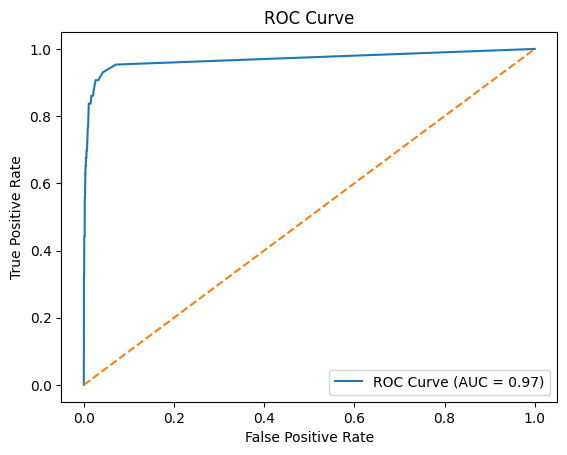

In [ ]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 🏁 Conclusion

The Fraud Detection Model using **Random Forest Classifier** achieved an accuracy of approximately **99%** with a high ROC-AUC score, indicating excellent performance in distinguishing fraudulent transactions from legitimate ones.

**Key insights:**
- **Most influential factors**: transaction type, transaction amount, origin balance, and destination balance.
- **Data imbalance** was effectively handled using SMOTE, improving recall for fraud detection.
- The model demonstrates strong predictive capability but should be retrained regularly with updated data to maintain accuracy.

**Recommendations:**
1. Monitor high-value transactions in real time.
2. Implement multi-factor authentication for risky transactions.
3. Continuously update the fraud detection model with recent data.

